### <img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393/578 Máquinas de Aprendizaje - 2019-1 </h1>

<H3 align='center'> Tarea 3  </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Manipulaciones en numpy
* Arboles de clasificación y regresión
* Algunas Redes neuronales básicas
* Ensamblados, Adaboost y Random Forest
* Nociones de clases desbalanceadas


**Formalidades**  
* Equipos de trabajo de 2 personas (*Ambos estudiantes deben estar preparados para presentar la tarea el día de la entrega*)
* El entregable debe ser un _Jupyter Notebook_ incluyendo los códigos utilizados, los resultados, los gráficos realizados y comentarios. Debe seguir una estructura similar a un informe (se debe introducir los problemas a trabajar, presentar los resultados y discutirlos). Si lo prefiere puede entregar un _Jupyter Notebook_ por pregunta o uno por toda la tarea, con tal de que todos los entregables esten bien identificados y se encuentren en el mismo repositorio de _Github_.
* Se debe preparar una presentación del trabajo realizado y sus hallazgos. El presentador será elegido aleatoriamente y deberá apoyarse en el _Jupyter Notebook_ que entregarán. 
* Formato de entrega: envı́o de link del repositorio *privado* en _Github_, al correo electrónico del ayudante (*<alvaro.valderrama.13@sansano.usm.cl>*), en copia al profesor (*<cvalle@inf.utfsm.cl>*). Especificar el siguiente asunto: [INF393/578-2019 Tarea 3]. Invitar como colaborador al usuario de github "avalderr" para poder acceder al repositorio.
* Fecha de entrega y presentaciones: 13 de Septiembre. Hora límite de entrega: 23:50. Cualquier _commit_ luego de la hora límite no será evaluado. Se realizará descuento por atrasos en envío del mail. 

<hr style="height:2px;border:none"/>

La tarea se divide en tres partes:

[1.](#primero) Regresión para ubicación espacial  
[2.](#segundo) Clasificación con clases desbalanceadas    
[3.](#tercero) Clasificación en texto   

La tarea tiene ejemplos de códigos con los cuales pueden guiarse en gran parte, sin embargo solo son guias y pueden ser creativos al momento de resolver la tarea. Soluciones creativas o elegantes serán valoradas. También en algunas ocaciones se hacen elecciones arbitrarias, ustedes pueden realizar otras elecciones con tal de que haya una pequeña justificación de por qué su elección es mejor o equivalente.
Recuerden intercalar su código con comentarios y con celdas _Markdown_ con los comentarios de la pregunta y con cualquier analisis, fórmula (en $ \LaTeX $) o explicación que les parezca relevante para justificar sus procedimientos. 
Noten que en general cuando se les pide elegir algo o proponer algo no se evaluará mucho la elección en si, en cambio la argumentación detrás de la elección será lo más ponderado.
Si algun modelo se demora demasiado en correr en su maquina, no olvide que puede correr _Jupyter Notebooks_ en _Collab_ de Google, esto puede ser relevante para las maquinas más lentas al momento de realizar exploraciones con _K-folds_ por ejemplo.

<a id="primero"></a>
## 1. Regresión para ubicación espacial

Un problema que tiene aplicaciones para muchos servicios es el calculo de la ubicación espacial exacta de un dispositivo conectado dentro de un edificio o un complejo de edificios. Estando dentro de un aeropuerto nuestro celular nos podría dar indicaciones para llegar a nuestra puerta de embarque o dentro de un mall encontrar la tienda que encontramos serían aplicaciones que fácilmente se desprenden de la solución a este problema. Actualmente en exteriores el problema se soluciona fácilmente mediante el uso de GPS, sin embargo en interiores el problema se vuelve más complicado pues hay considerable pérdida de la señar GPS y muchas superficies de construcción pueden resultar reflectantes para algunos tipos de señales por lo cual el problema es mucho más dificil de modelar que el problema en el exterior. 


En esta primera parte de la tarea utilizaremos un _dataset_ creado en 2013 con más de 20000 mediciones de posición dentro de 4 edificios de la universidad de Jaume, disponible en https://archive.ics.uci.edu/ml/datasets/UJIIndoorLoc junto con una detallada descripción. Nuestra tarea será predecir la ubicación espacial en latitud, longitud, y altura (en pisos) de los distintos usuarios que realizaron esta tarea, a partir de las intensidades de señal medidas por los 520 distintos puntos de acceso inalambricos. Para esto, probaremos utilizaremos arboles de regresión, regresión lineal y redes neuronales, comparando los distintos desempeños y las ventajas y desventajas de cada aproximación. 


#### 1.a Carga de datos

Cargue los datos de entrenamiento y validación y júntelos en un solo DataFrame como muestra el código. 

De los datos entregados luego del _target_ solo consideraremos el tipo de celular utilizado, convirtiendolo a variables _dummies_ como muestra el código. 

Separe el _target_ del resto de los datos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle

In [0]:
from google.colab import files
uploaded = files.upload()

Saving trainingData.csv to trainingData (1).csv
Saving validationData.csv to validationData (1).csv


In [2]:
df_tr = pd.read_csv("data/data_pregunta1/trainingData.csv")
df_val = pd.read_csv("data/data_pregunta1/validationData.csv")
#df_tr = pd.read_csv("trainingData.csv")
#df_val = pd.read_csv("validationData.csv")

In [3]:
df_tr.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [18]:
df_tr.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,WAP011,WAP012,WAP013,WAP014,WAP015,WAP016,WAP017,WAP018,WAP019,WAP020,WAP021,WAP022,WAP023,WAP024,WAP025,WAP026,WAP027,WAP028,WAP029,WAP030,WAP031,WAP032,WAP033,WAP034,WAP035,WAP036,WAP037,WAP038,WAP039,WAP040,...,WAP490,WAP491,WAP492,WAP493,WAP494,WAP495,WAP496,WAP497,WAP498,WAP499,WAP500,WAP501,WAP502,WAP503,WAP504,WAP505,WAP506,WAP507,WAP508,WAP509,WAP510,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
count,11254.000000,11254.0,11254.0,11254.0,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,11254.000000,...,11254.000000,11254.0,11254.0,11254.000000,11253.000000,11253.000000,11253.000000,11253.0,11253.0,11253.0,11253.000000,11253.000000,11253.000000,11253.000000,11253.000000,11253.0,11253.000000,11253.000000,11253.000000,11253.000000,11253.000000,11253.000000,11253.000000,11253.0,11253.0,11253.000000,11253.000000,11253.000000,11253.000000,11253.000000,11253.0,11253.000000,1.125300e+04,11253.000000,11253.000000,11253.000000,11253.000000,11253.000000,11253.000000,1.125300e+04
mean,99.739559,100.0,100.0,100.0,99.759641,95.051093,90.911409,95.332237,96.233162,99.316243,74.458948,74.686423,87.037320,86.807091,89.985694,89.505331,99.331882,99.453261,97.375511,97.384486,99.514661,99.499111,89.030389,89.140750,96.034388,96.050560,89.421539,88.863071,90.336414,89.874533,91.465523,91.464724,90.873201,90.836414,90.169629,89.881731,93.642083,93.865648,90.592412,90.596321,...,99.795184,100.0,100.0,99.991203,99.723807,72.860659,64.561539,100.0,100.0,100.0,99.568648,71.716253,62.758731,84.208655,99.693060,100.0,99.895761,99.965165,98.821736,99.982405,99.982494,86.173820,99.895850,100.0,100.0,99.707100,74.178175,68.085666,99.708611,99.947747,100.0,-7451.476352,4.864862e+06,1.778104,1.300631,154.886341,1.802719,8.100684,12.455523,1.371383e+09
std,7.129414,0.0,0.0,0.0,6.811165,29.936871,39.652790,29.046883,25.781792,11.452650,61.796801,61.513972,46.209777,46.606454,42.147031,43.118433,11.331734,10.240531,21.477503,21.472256,9.718636,9.855381,42.810725,42.572817,26.419090,26.363795,42.076207,43.141885,40.177448,41.153804,37.749435,37.707819,39.120158,39.208441,40.413559,41.011242,33.831261,33.226355,39.556494,39.533120,...,6.269850,0.0,0.0,0.933215,7.320124,63.279534,71.455990,0.0,0.0,0.0,9.142103,64.343567,72.941801,51.264010,7.669658,0.0,4.513328,2.612903,15.002158,1.866513,1.857086,48.356658,4.509518,0.0,0.0,7.530768,61.776639,68.716618,7.492522,3.200039,0.0,116.380215,6.600429e+01,1.251552,0.790539,58.209723,0.397964,3.021797,5.794418,6.642602e+05
min,-97.000000,100.0,100.0,100.0,-97.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,-101.000000,-101.000000,-98.000000,-98.000000,-101.000000,-99.000000,-98.000000,-98.000000,-99.000000,-99.000000,-98.000000,-98.000000,-100.000000,-99.000000,-98.000000,-98.000000,-99.000000,-98.000000,-98.000000,-99.000000,-99.000000,-101.000000,-98.000000,-98.000000,-100.000000,-98.000000,-98.000000,-98.000000,-100.000000,-98.000000,...,-96.000000,100.0,100.0,1.000000,-97.000000,-100.000000,-101.000000,100.0,100.0,100.0,-97.000000,-101.000000,-97.000000,-102.000000,-99.000000,100.0,-97.000000,-97.000000,-97.000000,-98.000000,-97.000000,-103.000000,-97.000000,100.0,100.0,-97.000000,-101.000000,-101.000000,-97.000000,-97.000000,100.0,-7691.338400,4.864746e+06,0.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.369909e+09
25%,100.000000,100.0,100.0,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1

In [0]:
print(df_tr.columns)

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP520', 'LONGITUDE', 'LATITUDE', 'FLOOR', 'BUILDINGID', 'SPACEID',
       'RELATIVEPOSITION', 'USERID', 'PHONEID', 'TIMESTAMP'],
      dtype='object', length=529)


In [4]:
df = shuffle(df_tr.append(df_val), random_state=0)

target_labels = [520,521,253]
# Indices del 1 al 259 sin los indices del target
attribute_labels = [l for l in range(len(df.columns)) if l not in target_labels]

target_cols =  df.columns[target_labels] 
print(target_cols)

Index(['LONGITUDE', 'LATITUDE', 'WAP254'], dtype='object')


In [5]:
# Para eliminar PHONEID ya que se pasará a categorical
phone_index = list(df.columns).index('PHONEID')
attribute_labels.remove(phone_index)

In [6]:
attribute_cols = df.columns[attribute_labels]

x_un = pd.get_dummies(df.PHONEID)
categorical_columns = x_un.columns
x_un[attribute_cols] = df[attribute_cols]

y_u = df[target_cols]

Separe los datos a partir de su índice, dejando un 80% de datos en el _train set_ y un 20% de validación. 
¿Por qué no es mala idea en este caso separar los datos a partir de su índice? ¿Qué problema podría tenerse en caso de no haber hecho `shuffle` al momento de cargar los datos? 


In [7]:
porcentaje_sep = 0.8
indice_sep = math.floor(x_un.shape[0]*0.8)

x_tr_un = x_un.iloc[0:indice_sep]
x_val_un = x_un.iloc[indice_sep:]

y_tr_u = y_u.iloc[0:indice_sep]
y_val_u = y_u.iloc[indice_sep:]

**Comentario**: En caso de no haber hecho shuffle podríamos estar sesgando los sets de training y de validación, en caso de que los datos vinieran ordenados de cierta manera en especifico. Ejemplo: que vinieran ordenados por ubucación, o por fuente de la que se obtuvieron los datos.

#### 1.b Estandarización de los datos

Utilice _Standar Scaler_ para los atributos no categóricos y para los datos categóricos simplemente sustraiga 0.5, como muestra el código. ¿Tiene realmente sentido estandarizar los datos categóricos (binarios) o le parece mejor la aproximación elegida?

Estandarice igualmente el _target_. Cabe mencionar que la tercera componente del target es el piso en el que se encuentra, variable categórica, preferiremos utilizarla como variable continua para ver que tan bien nuestros algoritmos pueden aproximar la ubicación y para facilitar la comparación de distintos modelos. 

In [8]:
scaler_x = StandardScaler()
scaler_x.fit(x_tr_un[attribute_cols])

x_tr = pd.np.concatenate((scaler_x.transform(x_tr_un[attribute_cols]), x_tr_un[categorical_columns].values-0.5), axis=1)
x_val = pd.np.concatenate((scaler_x.transform(x_val_un[attribute_cols]), x_val_un[categorical_columns].values-0.5), axis=1)

scaler_y = StandardScaler()
scaler_y.fit(y_tr_u)

y_tr = scaler_y.transform(y_tr_u)
y_val = scaler_y.transform(y_val_u)

#### 1.c Primer Arbol
Entrenaremos ahora un árbol de regresión con produndidad 3. Como métrica utilizaremos el Error Absoluto Medio o MAE a lo largo del resto de esta pregunta. ¿Qué tan bueno le parece el _score_ (coeficiente $R^2$) obtenido por el regresor?

Compare el desempeño del árbol, tanto en MAE como en _score_, en validación y entrenamiento, con respecto a un regresor lineal tradicional. ¿Cómo se comparan los tiempos de entrenamiento? ¿Le parece justificado el costo adicional?

In [24]:
from IPython.display import HTML, display
import tabulate

def display_metrics(model, name= ""):
    results = list()
    results.append(["MEDIDA", name])
    mse_tr = mean_squared_error(model.predict(x_tr),y_tr)
    mse_val = mean_squared_error(model.predict(x_val),y_val)
    results.append(["MSE TRAINING",  round(mse_tr,4)])
    results.append(["MSE VALIDATION",  round(mse_val,4)])

    # Uniform average
    score_tr = r2_score(model.predict(x_tr), y_tr)
    score_val = r2_score(model.predict(x_val), y_val)
    results.append(["R2_SCORE TRAINING (Uniform average)",  round(score_tr,4)])
    results.append(["R2_SCORE VALIDATION (Uniform average)",  round(score_val,4)])

    # Variance weighted
    score_tr = r2_score(model.predict(x_tr), y_tr, multioutput="variance_weighted")
    score_val = r2_score(tree_model.predict(x_val), y_val, multioutput="variance_weighted")
    results.append(["SCORE TRAINING (Variance weighted)",  round(score_tr,4)])
    results.append(["SCORE VALIDATION (Variance weighted)",  round(score_val,4)])

    # Raw values
    score_tr = r2_score(model.predict(x_tr), y_tr, multioutput="raw_values")
    score_val = r2_score(model.predict(x_val), y_val, multioutput="raw_values")
    results.append(["SCORE TRAINING (Raw values)",  list(map(lambda x: round(x,4), score_tr))])
    results.append(["SCORE VALIDATION (Raw values)",  list(map(lambda x: round(x,4), score_val))])


    print(tabulate.tabulate(results, headers="firstrow"))
#display(HTML(tabulate.tabulate(stump_results, tablefmt='html')))

In [9]:
tree_model = DecisionTreeRegressor(criterion='mae', max_depth=3)
tree_model.fit(x_tr, y_tr)

DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [10]:
mse_tr = mean_squared_error(tree_model.predict(x_tr),y_tr)
mse_val = mean_squared_error(tree_model.predict(x_val),y_val)

print("MSE TRAINING: ", mse_tr)
print("MSE VALIDATION: ", mse_val)

MSE TRAINING:  0.05635002962571209
MSE VALIDATION:  0.05190414873835466


In [11]:
# Variance weighted
score_tr = tree_model.score(x_tr,y_tr)
score_val = tree_model.score(x_val,y_val)

print("SCORE TRAINING: ", score_tr)
print("SCORE VALIDATION: ", score_val)

SCORE TRAINING:  0.9436499703742879
SCORE VALIDATION:  0.9513422749313866


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

In [12]:
tree_results = list()
tree_results.append(["MEDIDA", "TREE DEPTH 3"])

# MSE
mse_tr = mean_squared_error(tree_model.predict(x_tr),y_tr)
mse_val = mean_squared_error(tree_model.predict(x_val),y_val)
tree_results.append(["MSE TRAINING",  round(mse_tr,4)])
tree_results.append(["MSE VALIDATION",  round(mse_val,4)])

# Uniform average
score_tr = r2_score(tree_model.predict(x_tr), y_tr)
score_val = r2_score(tree_model.predict(x_val), y_val)
tree_results.append(["R2_SCORE TRAINING (Uniform average)",  round(score_tr,4)])
tree_results.append(["R2_SCORE VALIDATION (Uniform average)",  round(score_val,4)])

# Variance weighted
score_tr = r2_score(tree_model.predict(x_tr), y_tr, multioutput="variance_weighted")
score_val = r2_score(tree_model.predict(x_val), y_val, multioutput="variance_weighted")
tree_results.append(["SCORE TRAINING (Variance weighted)",  round(score_tr,4)])
tree_results.append(["SCORE VALIDATION (Variance weighted)",  round(score_val,4)])

# Raw values
score_tr = r2_score(tree_model.predict(x_tr), y_tr, multioutput="raw_values")
score_val = r2_score(tree_model.predict(x_val), y_val, multioutput="raw_values")
tree_results.append(["SCORE TRAINING (Raw values)",  list(map(lambda x: round(x,4), score_tr))])
tree_results.append(["SCORE VALIDATION (Raw values)",  list(map(lambda x: round(x,4), score_val))])

In [13]:
# Display tabular de los resultados

from IPython.display import HTML, display
import tabulate

print(tabulate.tabulate(tree_results, headers="firstrow"))
#display(HTML(tabulate.tabulate(stump_results, tablefmt='html')))

MEDIDA                                 TREE DEPTH 3
-------------------------------------  ------------------------
MSE TRAINING                           0.0564
MSE VALIDATION                         0.0519
R2_SCORE TRAINING (Uniform average)    0.937
R2_SCORE VALIDATION (Uniform average)  0.9405
SCORE TRAINING (Variance weighted)     0.9408
SCORE VALIDATION (Variance weighted)   0.9484
SCORE TRAINING (Raw values)            [0.957, 0.8721, 0.9818]
SCORE VALIDATION (Raw values)          [0.9548, 0.8687, 0.9979]


In [0]:
linear_model = LinearRegression()
linear_model.fit(x_tr, y_tr)

linear_results = list()
linear_results.append(["MEDIDA", "LINEAR MODEL"])

# MSE
mse_tr = mean_squared_error(linear_model.predict(x_tr),y_tr)
mse_val = mean_squared_error(linear_model.predict(x_val),y_val)
linear_results.append(["MSE TRAINING",  round(mse_tr,4)])
linear_results.append(["MSE VALIDATION",  round(mse_val,4)])

# Uniform average
score_tr = r2_score(linear_model.predict(x_tr), y_tr)
score_val = r2_score(linear_model.predict(x_val), y_val)
linear_results.append(["R2_SCORE TRAINING (Uniform average)",  round(score_tr,4)])
linear_results.append(["R2_SCORE VALIDATION (Uniform average)",  round(score_val,4)])

# Variance weighted
score_tr = r2_score(linear_model.predict(x_tr), y_tr, multioutput="variance_weighted")
score_val = r2_score(linear_model.predict(x_val), y_val, multioutput="variance_weighted")
linear_results.append(["SCORE TRAINING (Variance weighted)",  round(score_tr,4)])
linear_results.append(["SCORE VALIDATION (Variance weighted)",  round(score_val,4)])

# Raw values
score_tr = r2_score(linear_model.predict(x_tr), y_tr, multioutput="raw_values")
score_val = r2_score(linear_model.predict(x_val), y_val, multioutput="raw_values")
linear_results.append(["SCORE TRAINING (Raw values)",  list(map(lambda x: round(x,4), score_tr))])
linear_results.append(["SCORE VALIDATION (Raw values)",  list(map(lambda x: round(x,4), score_val))])

In [0]:
# Display tabular de los resultados

from IPython.display import HTML, display
import tabulate

print(tabulate.tabulate(linear_results, headers="firstrow"))
#display(HTML(tabulate.tabulate(stump_results, tablefmt='html')))

MEDIDA                                 LINEAR MODEL
-------------------------------------  ------------------------
MSE TRAINING                           0.0186
MSE VALIDATION                         8.430304145713041e+20
R2_SCORE TRAINING (Uniform average)    0.981
R2_SCORE VALIDATION (Uniform average)  -0.0001
SCORE TRAINING (Variance weighted)     0.981
SCORE VALIDATION (Variance weighted)   -0.0001
SCORE TRAINING (Raw values)            [0.9869, 0.9733, 0.9828]
SCORE VALIDATION (Raw values)          [-0.0002, -0.0, -0.0002]


**Comentario**: Se aprecia que el arbol tiene un error mucho mas bajo de validación, y un score mucho mayor de validacion. Se aprecia que el modelo lineal sufre de under fitting, ya que rinde bien para training y pésimo para validation. El arból de profundidad 3 parece predecir bastante bien.

#### 1.d _Stump_
Entrene ahora un _Stump_ o arbol de profundidad 1. ¿Cómo cambia el error (MAE) en entrenamiento y validación con respecto al árbol de la pregunta anterior? Discuta sobre el numero de parámetros entrenables que tendrá cada modelo.

In [0]:
stump_model =  DecisionTreeRegressor(criterion='mae', max_depth=1)
stump_model.fit(x_tr, y_tr)

DecisionTreeRegressor(criterion='mae', max_depth=1, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [0]:
# Ordenamos resultados

stump_results = list()
stump_results.append(["MEDIDA", "STUMP MODEL"])

# MSE
mse_tr = mean_squared_error(stump_model.predict(x_tr),y_tr)
mse_val = mean_squared_error(stump_model.predict(x_val),y_val)
stump_results.append(["MSE TRAINING",  round(mse_tr,4)])
stump_results.append(["MSE VALIDATION",  round(mse_val,4)])

# Uniform average
score_tr = r2_score(stump_model.predict(x_tr), y_tr)
score_val = r2_score(stump_model.predict(x_val), y_val)
stump_results.append(["R2_SCORE TRAINING (Uniform average)",  round(score_tr,4)])
stump_results.append(["R2_SCORE VALIDATION (Uniform average)",  round(score_val,4)])

# Variance weighted
score_tr = r2_score(stump_model.predict(x_tr), y_tr, multioutput="variance_weighted")
score_val = r2_score(stump_model.predict(x_val), y_val, multioutput="variance_weighted")
stump_results.append(["SCORE TRAINING (Variance weighted)",  round(score_tr,4)])
stump_results.append(["SCORE VALIDATION (Variance weighted)",  round(score_val,4)])

# Raw values
score_tr = r2_score(stump_model.predict(x_tr), y_tr, multioutput="raw_values")
score_val = r2_score(stump_model.predict(x_val), y_val, multioutput="raw_values")
stump_results.append(["SCORE TRAINING (Raw values)",  list(map(lambda x: round(x,4), score_tr))])
stump_results.append(["SCORE VALIDATION (Raw values)",  list(map(lambda x: round(x,4), score_val))])

In [0]:
# Display tabular de los resultados

from IPython.display import HTML, display
import tabulate

print(tabulate.tabulate(stump_results,  headers="firstrow"))
#display(HTML(tabulate.tabulate(stump_results, tablefmt='html')))

MEDIDA                                 STUMP MODEL
-------------------------------------  -----------------------------------------
MSE TRAINING                           0.5668
MSE VALIDATION                         0.7462
R2_SCORE TRAINING (Uniform average)    -1.9825959122625624e+27
R2_SCORE VALIDATION (Uniform average)  -3.457307632128715e+28
SCORE TRAINING (Variance weighted)     -0.078
SCORE VALIDATION (Variance weighted)   -0.4117
SCORE TRAINING (Raw values)            [0.6525, 0.4446, -5.947787736787687e+27]
SCORE VALIDATION (Raw values)          [0.6567, 0.4398, -1.0371922896386145e+29]


**Comentario**: Este modelo lo hace mejor que el modelo linea, pero tiene un score pésimo. Por lo tanto es peor que el arbol de profundidad 3. Sufré de underfitting, ya que no posee los suficientes parámetros para predecir bien el problema.

#### 1.e Profundidad máxima
Explore distintos valores de la profundidad máxima del árbol. Para esto, realice K-fold sobre al menos 10 valores distintos de la profundidad del árbol y compare el promedio de los MAE de validación. También guarde los promedios de MAE de _train_ y grafique como estos varían a medida varia la profundidad máxima. Idealmente debería considerar un rango entre profundidad máxima 1 y 20. Note que este paso puede resultar largo en tiempo de cómputo, podría ser recomendable correrlo en _Collab_ en caso de tener máquinas más lentas. 

Finalmente, entrene el arbol con profundidad óptima sobre todos los datos de entrenamiento y calcule su MAE sobre validación. ¿Mejoramos el desempeño obtenido anteriormente con los árboles sin sintonizar? 

Primero que nada, como el cómputo puede que demore bastante, creamos algunas funciones para mostrar una barra de progreso.

In [14]:
# Auxiliares para mostrar progreso 

import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [0]:
from sklearn.model_selection import KFold

X_tr_kfold = pd.np.concatenate((x_tr, x_val))
y_tr_kfold = pd.np.concatenate((y_tr, y_val))
kf = KFold(n_splits=5)
print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [0]:
depth_values = list(range(2,12))
scores_by_depth_tr = list()
scores_by_depth_val = list()
errors_by_depth_tr = list()
errors_by_depth_val = list()

for i in range(len(depth_values)):
    update_progress(i / len(depth_values))
    depth_i = depth_values[i]
    fold_scores_tr = list()
    fold_scores_val = list()
    fold_errors_tr = list()
    fold_errors_val = list()
    for train_index, test_index in kf.split(X_tr_kfold):       
        X_train_cross, X_test_cross = X_tr_kfold[train_index,:], X_tr_kfold[test_index,:]
        y_train_cross, y_test_cross = y_tr_kfold[train_index,:], y_tr_kfold[test_index,:]

        # Entreno del modelo
        kfold_model = DecisionTreeRegressor(criterion='mae', max_depth=depth_i)
        kfold_model.fit(X_train_cross, y_train_cross)
        
        # Training Error
        error_tr = mean_squared_error(kfold_model.predict(X_train_cross), y_train_cross)
        # Validation Error
        error_val = mean_squared_error(kfold_model.predict(X_test_cross), y_test_cross)
        # Training Score 
        score_tr = r2_score(kfold_model.predict(x_tr), y_tr)
        # Validation Score
        score_val = r2_score(kfold_model.predict(x_val), y_val)
        
        # Guardar resultados de este fold
        fold_errors_tr.append(error_tr)
        fold_errors_val.append(error_val)
        fold_scores_tr.append(score_tr)
        fold_scores_val.append(score_val)
   
    errors_by_depth_tr.append((sum(fold_errors_tr)/len(fold_errors_tr)))
    errors_by_depth_val.append((sum(fold_errors_val)/len(fold_errors_val)))
    scores_by_depth_tr.append((sum(fold_scores_tr)/len(fold_scores_tr)))
    scores_by_depth_val.append((sum(fold_scores_val)/len(fold_scores_val)))

update_progress(1)

Progress: [####################] 100.0%


In [0]:
print(scores_by_depth_tr)
print(scores_by_depth_val)
print(errors_by_depth_tr)
print(errors_by_depth_val)

[-1.2909829791566681e+29, 0.9371677568935171, 0.96129511683201, 0.9765793102198602, 0.9830584442277688, 0.9861379278779767, 0.9889161905817094, 0.9918400397246547, 0.9925019107631684, 0.9949074518233276]
[-1.9744322767595455e+29, 0.941000489305311, 0.9666211675032821, 0.9775338200497974, 0.9837694934594706, 0.9881777091890112, 0.9908222533347608, 0.9927058773631174, 0.9945951688350281, 0.9962944620251436]
[0.4445343822131084, 0.0553958862176551, 0.036428521858397095, 0.021634408868292453, 0.015371758259827204, 0.011314859357878026, 0.008560979854644383, 0.006739373452331688, 0.004942154389974705, 0.0034865177487927125]
[0.4445666049389702, 0.05552117215069572, 0.03648920741364901, 0.026569636389113648, 0.020726737529682727, 0.021084159894038362, 0.018705554246377515, 0.0127285146783707, 0.01539769932617605, 0.010084422559150213]


In [0]:
scores_by_depth_tr = [-1.2909829791566681e+29, 0.9371677568935171, 0.96129511683201, 0.9765793102198602, 0.9830584442277688, 0.9861379278779767, 0.9889161905817094, 0.9918400397246547, 0.9925019107631684, 0.9949074518233276]
scores_by_depth_val = [-1.9744322767595455e+29, 0.941000489305311, 0.9666211675032821, 0.9775338200497974, 0.9837694934594706, 0.9881777091890112, 0.9908222533347608, 0.9927058773631174, 0.9945951688350281, 0.9962944620251436]
errors_by_depth_tr = [0.4445343822131084, 0.0553958862176551, 0.036428521858397095, 0.021634408868292453, 0.015371758259827204, 0.011314859357878026, 0.008560979854644383, 0.006739373452331688, 0.004942154389974705, 0.0034865177487927125]
errors_by_depth_val =[0.4445666049389702, 0.05552117215069572, 0.03648920741364901, 0.026569636389113648, 0.020726737529682727, 0.021084159894038362, 0.018705554246377515, 0.0127285146783707, 0.01539769932617605, 0.010084422559150213]

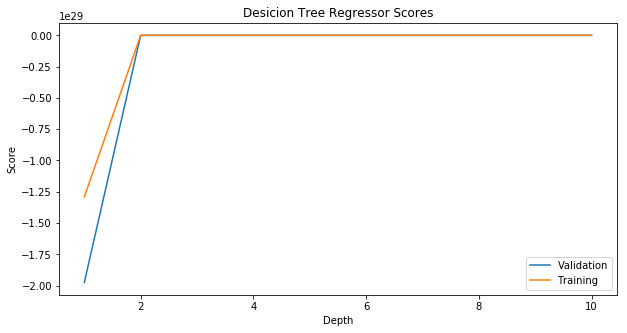

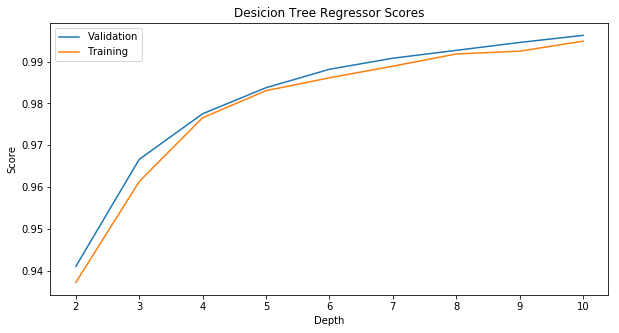

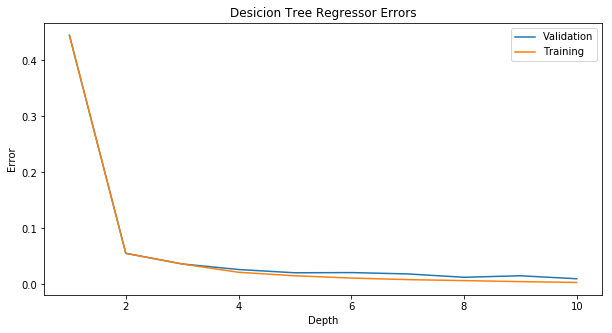

In [8]:
import matplotlib.pyplot as plt
depths = range(1,11)

plt.figure(figsize=(10,5))    
plt.plot( depths, scores_by_depth_val, label="Validation") 
plt.plot( depths, scores_by_depth_tr, label="Training") 
        
plt.xlabel("Depth")
plt.ylabel("Score")
plt.title("Desicion Tree Regressor Scores")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))    
plt.plot( depths[1:], scores_by_depth_val[1:], label="Validation") 
plt.plot( depths[1:], scores_by_depth_tr[1:], label="Training") 
        
plt.xlabel("Depth")
plt.ylabel("Score")
plt.title("Desicion Tree Regressor Scores")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))    
plt.plot( depths, errors_by_depth_val, label="Validation") 
plt.plot( depths, errors_by_depth_tr, label="Training") 
        
plt.xlabel("Depth")
plt.ylabel("Error")
plt.title("Desicion Tree Regressor Errors")
plt.legend()
plt.show()

Ahora sin kfold iremos probando valores mas elevados para ver si en algún momento se sobreajusta el árbol.

In [19]:
depth_values = list(range(400,1001,100))
scores_by_depth_tr_2 = list()
scores_by_depth_val_2 = list()
errors_by_depth_tr_2 = list()
errors_by_depth_val_2 = list()

for i in range(len(depth_values)):
    update_progress(i / len(depth_values))
    depth_i = depth_values[i]

    # Entreno del modelo
    kfold_model = DecisionTreeRegressor(criterion='mae', max_depth=depth_i)
    kfold_model.fit(x_tr, y_tr)

    # Training Error
    error_tr = mean_squared_error(kfold_model.predict(x_tr), y_tr)
    # Validation Error
    error_val = mean_squared_error(kfold_model.predict(x_val), y_val)
    # Training Score 
    score_tr = r2_score(kfold_model.predict(x_tr), y_tr)
    # Validation Score
    score_val = r2_score(kfold_model.predict(x_val), y_val)
        
    errors_by_depth_tr_2.append(error_tr)
    errors_by_depth_val_2.append(error_val)
    scores_by_depth_tr_2.append(score_tr)
    scores_by_depth_val_2.append(score_val)
    
update_progress(1)

Progress: [####################] 100.0%


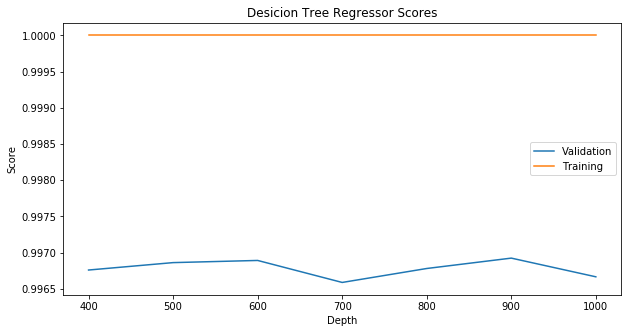

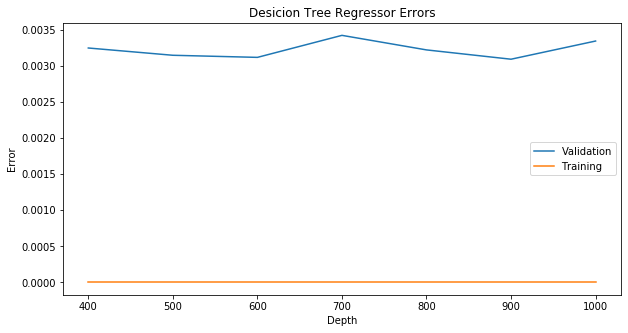

In [20]:
import matplotlib.pyplot as plt
depths = depth_values

plt.figure(figsize=(10,5))    
plt.plot( depths, scores_by_depth_val_2, label="Validation") 
plt.plot( depths, scores_by_depth_tr_2, label="Training") 
        
plt.xlabel("Depth")
plt.ylabel("Score")
plt.title("Desicion Tree Regressor Scores")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))    
plt.plot( depths, errors_by_depth_val_2, label="Validation") 
plt.plot( depths, errors_by_depth_tr_2, label="Training") 
        
plt.xlabel("Depth")
plt.ylabel("Error")
plt.title("Desicion Tree Regressor Errors")
plt.legend()
plt.show()

In [32]:
depth_values = list(range(2000,10001,1000))
scores_by_depth_tr_2 = list()
scores_by_depth_val_2 = list()
errors_by_depth_tr_2 = list()
errors_by_depth_val_2 = list()

for i in range(len(depth_values)):
    update_progress(i / len(depth_values))
    depth_i = depth_values[i]

    # Entreno del modelo
    kfold_model = DecisionTreeRegressor(criterion='mae', max_depth=depth_i)
    kfold_model.fit(x_tr, y_tr)

    # Training Error
    error_tr = mean_squared_error(kfold_model.predict(x_tr), y_tr)
    # Validation Error
    error_val = mean_squared_error(kfold_model.predict(x_val), y_val)
    # Training Score 
    score_tr = r2_score(kfold_model.predict(x_tr), y_tr)
    # Validation Score
    score_val = r2_score(kfold_model.predict(x_val), y_val)
        
    errors_by_depth_tr_2.append(error_tr)
    errors_by_depth_val_2.append(error_val)
    scores_by_depth_tr_2.append(score_tr)
    scores_by_depth_val_2.append(score_val)
    
update_progress(1)

Progress: [####################] 100.0%


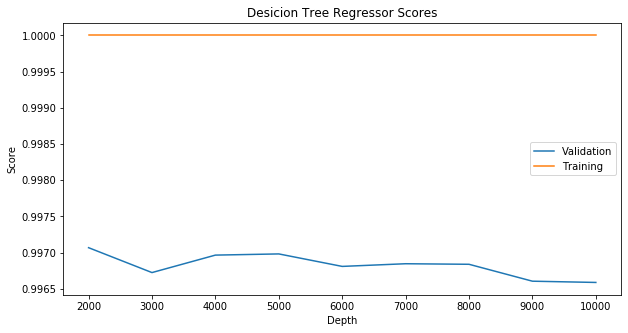

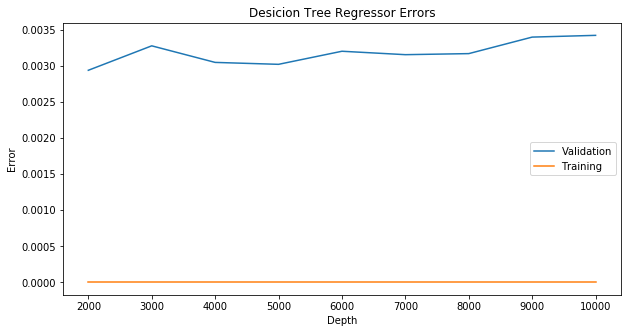

In [33]:
import matplotlib.pyplot as plt
depths = depth_values

plt.figure(figsize=(10,5))    
plt.plot( depths, scores_by_depth_val_2, label="Validation") 
plt.plot( depths, scores_by_depth_tr_2, label="Training") 
        
plt.xlabel("Depth")
plt.ylabel("Score")
plt.title("Desicion Tree Regressor Scores")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))    
plt.plot( depths, errors_by_depth_val_2, label="Validation") 
plt.plot( depths, errors_by_depth_tr_2, label="Training") 
        
plt.xlabel("Depth")
plt.ylabel("Error")
plt.title("Desicion Tree Regressor Errors")
plt.legend()
plt.show()

**Conclusión pregunta e:** Se aprecia que a medida que avanza la profundidad del árbol entre los valores 1 y 20, el modelo mejora. Para provocar un sobreajuste se intento con profundidades hasta 10000. Si bien el error de validación se separó algo de el de training, fue un valor muy pequeño, asi que no se podría decir que esta sobreajustado aún.

#### 1.f Random Forest

En la pregunta anterior vimos que una profundidad de árbol muy grande puede llevarnos a _overffiting_, pues la cantidad de "decisiones" que puede aprender el modelo aumentan significativamente y el modelo tenderá a aprender de memoria el conjunto de entrenamiento, perdiendo capacidad de generalización. Otra aproximación para evitar _overffiting_ no utilizar todos los datos para entrenar, estrategia implementada por _Random Forest_. 

Discuta por qué el utilizar muchos modelos que no conocen todos los datos puede ayudar a mejorar la capacidad de generalización, evitando así que el modelo final este sobreajustado. Entrene luego un _Random Forest Regressor_, con a lo menos 10 árboles. Discuta sobre que elección realizar sobre la profundidad máxima de estos árboles. ¿Cómo se compara el desempeño de _Random Forest_ frente a un árbol por si solo?

In [21]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=20,
                               criterion='mae',
                               max_depth=5)

forest.fit(x_tr, y_tr)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [26]:
display_metrics(forest, "Random Forest")

MEDIDA                                 Random Forest
-------------------------------------  ------------------------
MSE TRAINING                           0.0206
MSE VALIDATION                         0.0217
R2_SCORE TRAINING (Uniform average)    0.9788
R2_SCORE VALIDATION (Uniform average)  0.9776
SCORE TRAINING (Variance weighted)     0.979
SCORE VALIDATION (Variance weighted)   0.9484
SCORE TRAINING (Raw values)            [0.9836, 0.9552, 0.9974]
SCORE VALIDATION (Raw values)          [0.9827, 0.9535, 0.9965]


**Comentario**: Podría ser mejor un bosqué en que los árboles hayan sido entrenados con distintos conjuntos de entrenamiento, de esta manera la decisión final no podrá estar sesgada a solo cierto grupo de entrenamiento.

**Comentario**: Se aprencia que el modelo rindió bastante bien, el score es cercano a 1, aúnque no es mejor que el realizado por los árboles de profundidad 20 o superior vistos en las preguntas anteriores. También el MSE es algo mayor a el logrado por los árboles mencionados.

#### 1.g Otros parámetros

Por último, investigue un poco sobre los otros parámetros de los árboles y sus implicancias. Luego, entrene un arbol modificando algunos de sus parámetros de una forma que piensen podría haber mejorado el desempeño. Discuta

**min_impurity_decrease**: Lo que hace min_impurity_decrease, es que cada vez que se quiera dividir un nodo, si esta mejora la pureza del set en tal valor o mas, se separará. De lo contrario se dejará como un nodo hoja.

**min_samples_split**: Lo que hace este parametro, es asignar la cantidad minima de ejemplos que tiene que haber en un set en cierto nodo, para seguir separando este. Si el valor es menor a este parametro el nodo no se separará y quedará como un nodo hoja.

In [ ]:
#tree = DecisionTreeRegressor(criterion='mae',
#                            max_depth=None,
#                           min_impurity_decrease=0.1, # for instance
#                           min_samples_split=int(x_tr.shape[0]*0.05) #for instance
                            #)

In [30]:
# Modificando min_samples_split

samples_values = list(np.arange(0.01, 0.2, 0.02))
scores_by_samples_tr = list()
scores_by_samples_val = list()
errors_by_samples_tr = list()
errors_by_samples_val = list()

for i in range(len(imp_values)):
    update_progress(i / len(samples_values))
    samples = samples_values[i]

    # Entreno del modelo
    kfold_model = DecisionTreeRegressor(criterion='mae', max_depth=None, min_samples_split=int(x_tr.shape[0]*samples))
    kfold_model.fit(x_tr, y_tr)

    # Training Error
    error_tr = mean_squared_error(kfold_model.predict(x_tr), y_tr)
    # Validation Error
    error_val = mean_squared_error(kfold_model.predict(x_val), y_val)
    # Training Score 
    score_tr = r2_score(kfold_model.predict(x_tr), y_tr)
    # Validation Score
    score_val = r2_score(kfold_model.predict(x_val), y_val)
        
    errors_by_samples_tr.append(error_tr)
    errors_by_samples_val.append(error_val)
    scores_by_samples_tr.append(score_tr)
    scores_by_samples_val.append(score_val)
update_progress(1)
                                        


Progress: [####################] 100.0%


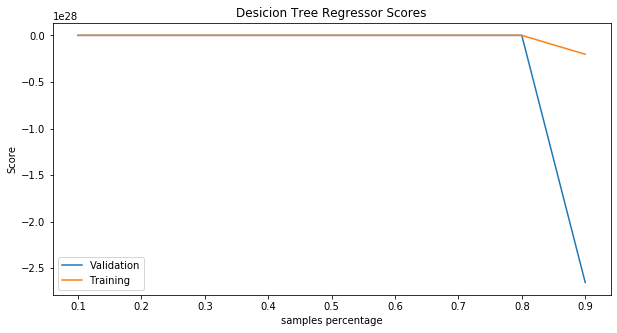

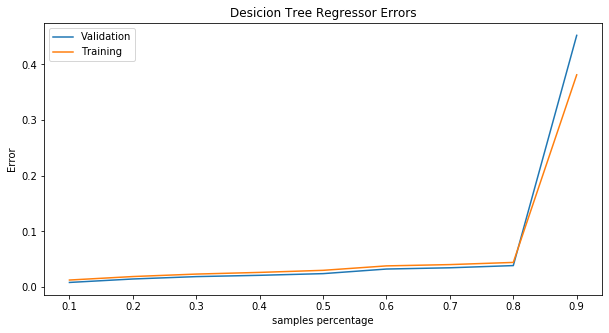

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))    
plt.plot( imp_values, scores_by_samples_val, label="Validation") 
plt.plot( imp_values, scores_by_samples_tr, label="Training") 
        
plt.xlabel("samples percentage")
plt.ylabel("Score")
plt.title("Desicion Tree Regressor Scores")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))    
plt.plot( imp_values, errors_by_samples_val, label="Validation") 
plt.plot( imp_values, errors_by_samples_tr, label="Training") 
        
plt.xlabel("samples percentage")
plt.ylabel("Error")
plt.title("Desicion Tree Regressor Errors")
plt.legend()
plt.show()

In [ ]:
# Modificando min_impurity_decrease

imp_values = list(np.arange(0.1, 1, 0.1))
scores_by_imp_tr = list()
scores_by_imp_val = list()
errors_by_imp_tr = list()
errors_by_imp_val = list()

for i in range(len(imp_values)):
    update_progress(i / len(imp_values))
    imp = imp_values[i]

    # Entreno del modelo
    kfold_model = DecisionTreeRegressor(criterion='mae', max_depth=None, min_impurity_decrease= imp)
    kfold_model.fit(x_tr, y_tr)

    # Training Error
    error_tr = mean_squared_error(kfold_model.predict(x_tr), y_tr)
    # Validation Error
    error_val = mean_squared_error(kfold_model.predict(x_val), y_val)
    # Training Score 
    score_tr = r2_score(kfold_model.predict(x_tr), y_tr)
    # Validation Score
    score_val = r2_score(kfold_model.predict(x_val), y_val)
        
    errors_by_imp_tr.append(error_tr)
    errors_by_imp_val.append(error_val)
    scores_by_imp_tr.append(score_tr)
    scores_by_imp_val.append(score_val)
update_progress(1)

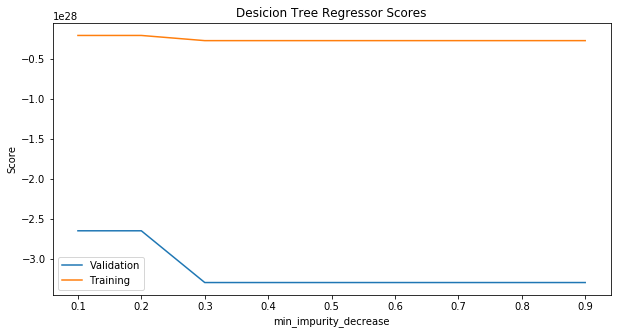

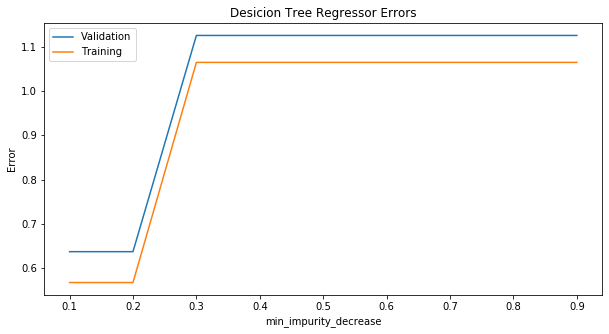

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))    
plt.plot( imp_values, scores_by_imp_val, label="Validation") 
plt.plot( imp_values, scores_by_imp_tr, label="Training") 
        
plt.xlabel("min_impurity_decrease")
plt.ylabel("Score")
plt.title("Desicion Tree Regressor Scores")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))    
plt.plot( imp_values, errors_by_imp_val, label="Validation") 
plt.plot( imp_values, errors_by_imp_tr, label="Training") 
        
plt.xlabel("min_impurity_decrease")
plt.ylabel("Error")
plt.title("Desicion Tree Regressor Errors")
plt.legend()
plt.show()

**Comentario:** En ambos experimentos se aprecian distintas variaciones en el desempeño según se varían las métricas estudiadas, sin embargo todos estos modelos encontrados son peores que los modelos anteriores.